In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Dyetec

/content/drive/MyDrive/Dyetec


## Settings

In [ ]:
!pip install colormath

In [ ]:
import os
import random
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cmc

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

### Configurations

In [ ]:
# Configs
SEED = 42

# XGBoost
BOOSTER = 'gbtree' # default. Gradient Boosting tree
LR = 0.1
MAX_DEPTH = 20
N_ESTIMATORS = 100
OBJECTIVE = 'reg:squarederror'
SILENT = False
SUBSAMPLE = 1.0  # Subsample ratio from the training set

colsample_bylevel = 1.0
colsample_bytree = 1.0
EARLY_STOPPING_ROUNDS = 10  # 에러가 n번 증가하면 학습 중단, default 10
GAMMA = 0.0
MAX_DELTA_STEP = 0.0
min_child_weights = 1.0 # Minimum sum of weights needed in each child node for a split.
num_parallel_tree = 1

# 'dart'인 경우에만 적용 - overfitting 방지
NORMALIZE_TYPE = 'tree' # how to normalize trees, default 'tree'
ONE_DROP = True # 1개 이상의 트리를 드롭아웃
RATE_DROP = 0.5  # 각 트리를 드롭아웃할 확률, default 0.0
REG_ALPHA = 0.2  # L1 regularization on the weights, default 0.0
REG_LAMBDA = 0.8 # L2 regularization on the weights, default 1.0
SAMPLE_TYPE = 'weighted' # 드롭아웃 확률을 트리의 가중치에 비례하게, default 'uniform'
SKIP_DROP = 0.2  # skipping the dropout during a given iteration, default 0.0


In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## Data Loading

In [ ]:
df = pd.read_excel('rawdata.xlsx', skiprows=2)
df.drop(labels=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(columns=['태그'], inplace=True)
df = df.iloc[:, :54]
df

,Lab 후가공 후 검사_L*,Lab 후가공 후 검사_b*,Lab 후가공 후 검사_a*,Dianix Yellow AM-2R,Dianix Red AM-SLR,Dianix Blue AM-2G,Dorosperse Yellow KKL,Synolon Yellow AK,Dorosperse Red KKL,Synolon Red AK,Synolon Blue AK,Dorosperse Blue KKL,Dorosperse Yellow KKL_prop,Dorosperse Red KKL_prop,Dianix Red AM-SLR_prop,Dianix Blue AM-2G_prop,Dianix Yellow AM-2R_prop,Dorosperse Blue KKL_prop,Synolon Yellow AK_prop,Synolon Red AK_prop,Synolon Blue AK_prop,Dianix Yellow Brown AM-R,Synofast 28,Dorosperse Dark Grey KKL,Dorosperse B/K KKL,...,Synolon Dark Grey AK,Lab 염색 상승온도 #3 유지시간,Lab 염색 상승속도 #3,Lab 염색 상승온도 #3,배합_Sera Fast P-UVC,배합_UVK-400 H/C,배합_Fadex® TS liq,후처리_Sera Con M-FAS,Lab 염색 상승속도 #2,Lab 염색 하강속도 #1,Synofast 28_prop,Dianix Grey AM-SLR_prop,전처리_CH3COOH,배합_빙초산,Dorosperse Dark Grey KKL_prop,Dorosperse B/K KKL_prop,Dianix Black AM-SLR_prop,Dianix Yellow Brown AM-R_prop,배합_UVK-200,제직_중량_생지,Dorosperse Brown K-3LR_prop,Lab 염색 상승속도 #1,후처리_NaOH,Synolon Black AK-NB_prop,Synolon Dark Grey AK_prop
0,50.510,9.480,10.5500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
1,51.460,9.790,10.0100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
2,51.870,9.480,10.2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,4.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,4.0,237.0,0.0,1.5,2.0,0.0,0.0
3,48.930,9.570,10.9200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,0.0,0.0,0.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
4,49.580,9.790,10.5200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.500000,136.0,4.0,0.0,4.0,2.0,0.75,2.00000,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,237.0,0.0,1.5,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,48.260,50.385,57.3950,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,70.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1680,48.250,50.180,57.0850,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1681,69.100,84.880,30.2775,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,0.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0
1682,69.835,84.570,29.0850,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,1.458333,135.0,0.0,0.0,2.0,4.0,0.75,1.97222,0.0,0.0,1.0,0.2,0.0,0.0,0.0,0.0,0.0,242.0,0.0,1.5,2.0,0.0,0.0


### 컬럼명 변경

In [ ]:
kr2en = {'Lab 후가공 후 검사_L*': 'L*', 
         'Lab 후가공 후 검사_a*': 'a*', 
         'Lab 후가공 후 검사_b*': 'b*',
         '전처리_CH3COOH': 'prep_CH3COOH', 
         '제직_중량_생지': 'weaving_dough', 
         '배합_Sera Fast P-UVC': 'comb_Sera Fast', 
         '배합_UVK-400 H/C': 'comb_UVK400', 
         '배합_Fadex® TS liq': 'comb_Fadex', 
         '배합_빙초산': 'comb_acid',
         '배합_UVK-200': 'comb_UVK200',
         'Lab 염색 상승속도 #1': 'dye_up_rate1', 
         'Lab 염색 상승속도 #2': 'dye_up_rate2', 
         'Lab 염색 상승속도 #3': 'dye_up_rate3', 
         'Lab 염색 상승온도 #3': 'dye_up_temp3', 
         'Lab 염색 상승온도 #3 유지시간': 'dye_up_temp3_hold', 
         'Lab 염색 하강속도 #1': 'dye_down_rate1',
         '후처리_Sera Con M-FAS': 'after_Sera', 
         '후처리_NaOH': 'after_NaOH'
}

for col in df.columns:
    if col not in kr2en.keys(): continue
    df.rename(columns={col: kr2en[col]}, inplace=True)

df.columns

Index(['L*', 'b*', 'a*', 'Dianix Yellow AM-2R', 'Dianix Red AM-SLR',
       'Dianix Blue AM-2G', 'Dorosperse Yellow KKL', 'Synolon Yellow AK',
       'Dorosperse Red KKL', 'Synolon Red AK', 'Synolon Blue AK',
       'Dorosperse Blue KKL', 'Dorosperse Yellow KKL_prop',
       'Dorosperse Red KKL_prop', 'Dianix Red AM-SLR_prop',
       'Dianix Blue AM-2G_prop', 'Dianix Yellow AM-2R_prop',
       'Dorosperse Blue KKL_prop', 'Synolon Yellow AK_prop',
       'Synolon Red AK_prop', 'Synolon Blue AK_prop',
       'Dianix Yellow Brown AM-R', 'Synofast 28', 'Dorosperse Dark Grey KKL',
       'Dorosperse B/K KKL', 'Dianix Black AM-SLR', 'Dorosperse Brown K-3LR',
       'Dianix Grey AM-SLR', 'Synolon Black AK-NB', 'Synolon Dark Grey AK',
       'dye_up_temp3_hold', 'dye_up_rate3', 'dye_up_temp3', 'comb_Sera Fast',
       'comb_UVK400', 'comb_Fadex', 'after_Sera', 'dye_up_rate2',
       'dye_down_rate1', 'Synofast 28_prop', 'Dianix Grey AM-SLR_prop',
       'prep_CH3COOH', 'comb_acid', 'Dorosperse

### Train & Test Split

In [ ]:
X, y = df.iloc[:,3:], df.iloc[:,:3]
print(X.shape, y.shape)

(1684, 51) (1684, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1347, 51) (1347, 3)
(337, 51) (337, 3)


## Modelling

### Model Parameters

In [ ]:
model = MultiOutputRegressor(xgb.XGBRegressor(
    booster=BOOSTER, # 'dart': Adds dropout to the standard gradient boosting algorithm
    learning_rate=LR,
    max_depth=MAX_DEPTH,
    n_estimators=N_ESTIMATORS,
    objective=OBJECTIVE,
    silent=SILENT,
    subsample=SUBSAMPLE,
    
    # colsample_bylevel = 1.0,
    # colsample_bytree = 1.0,
    # early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    # gamma=GAMMA,
    # max_delta_step=MAX_DELTA_STEP,
    # min_child_weights=MIN_CHILD_WEIGHTS,
    # num_parallel_tree=NUM_PARALLEL_TREE,

    # 'dart'인 경우에만 적용
    # one_drop=ONE_DROP, # 1개 이상의 트리를 드롭아웃
    # rate_drop=RATE_DROP,  # 각 트리를 드롭아웃할 확률
    # reg_alpha=REG_ALPHA,  # L1 regularization on the weights
    # reg_lambda=REG_LAMBDA, # L2 regularization on the weights
    # normalize_type=NORMALIZE_TYPE,
    # sample_type=SAMPLE_TYPE,
    # skip_drop=SKIP_DROP,
))

### Training

In [ ]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(max_depth=20,
                                            objective='reg:squarederror',
                                            silent=False, subsample=1.0))

### Prediction

In [ ]:
y_pred = model.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['L_pred', 'a_pred', 'b_pred'])

In [ ]:
y_train_pred = model.predict(X_train)
df_train_pred = pd.DataFrame(y_train_pred, columns=['L_train_pred', 'a_train_pred', 'b_train_pred'])

## Performance Evaluation
- Lab 한꺼번에 학습 및 예측한 결과만!!
- R-sqaured, MSE
- CMC 2:1 색차값

### R-squared, MSE

In [ ]:
print(f'[Train] R-squared for L,a,b: {round(model.score(X_train, y_train),6)}')
print(f'[Test]  R-squared for L,a,b: {round(model.score(X_test, y_test),6)}')

print(f'\n[Train] MSE for L,a,b: {round(mean_squared_error(y_train, y_train_pred), 4)}')
print(f'[Test]  MSE for L,a,b: {round(mean_squared_error(y_test, y_pred),4)}')

[Train] R-squared for L,a,b: 0.999967
[Test]  R-squared for L,a,b: 0.983285

[Train] MSE for L,a,b: 0.0161
[Test]  MSE for L,a,b: 8.1655


### CMC 색차값, ΔE 계산 (Train)

In [ ]:
def compute_delta_e(y_test, y_pred):
    delta_E_21 = []
    for i, (L_pred, a_pred, b_pred) in enumerate(y_pred):
        L_test, a_test, b_test = y_test.iloc[i].values
        target_color = LabColor(L_test, a_test, b_test)
        pred_color = LabColor(L_pred, a_pred, b_pred)
        delta_E_21.append(delta_e_cmc(target_color, pred_color, pl=2, pc=1))
    return delta_E_21

In [ ]:
df_train_pred['Delta_E'] = compute_delta_e(y_train, y_train_pred)
df_train_pred['Below 1'] = (df_train_pred['Delta_E'] < 1)

pd.concat([y_train.reset_index(drop=True), df_train_pred], axis=1)

,L*,b*,a*,L_train_pred,a_train_pred,b_train_pred,Delta_E,Below 1
0,30.910,18.210,-14.940,30.986078,18.207300,-14.939195,0.046451,True
1,18.420,-0.925,-0.275,18.460079,-0.922222,-0.250373,0.050068,True
2,70.290,-15.080,-9.170,70.243782,-15.110765,-9.197952,0.032557,True
3,49.050,-0.430,0.555,49.438789,-0.429117,0.442016,0.245047,True
4,40.340,14.935,57.035,40.618549,14.928461,57.038582,0.144349,True
...,...,...,...,...,...,...,...,...
1342,61.770,56.565,30.525,61.790859,56.563934,30.515070,0.010319,True
1343,18.370,-0.830,0.085,18.392471,-0.821590,0.094382,0.026932,True
1344,25.050,-27.255,-1.930,25.008400,-27.226295,-1.982982,0.049394,True
1345,78.970,76.770,14.785,79.013977,76.766922,14.782903,0.016321,True


In [ ]:
print(f"[Train] CMC(2:1) ΔE < 1 : {df_train_pred['Below 1'].sum()} / {len(df_train_pred)} = {df_train_pred['Below 1'].mean():.4f}")
print(f"[Train] CMC(2:1) Average of ΔE : {df_train_pred['Delta_E'].mean():.4f}")

[Train] CMC(2:1) ΔE < 1 : 1345 / 1347 = 0.9985
[Train] CMC(2:1) Average of ΔE : 0.0919


### CMC 색차값, ΔE 계산 (Test)

In [ ]:
df_pred['Delta_E'] = compute_delta_e(y_test, y_pred)
df_pred['Below 1'] = (df_pred['Delta_E'] < 1)

pd.concat([y_test.reset_index(drop=True), df_pred], axis=1)

,L*,b*,a*,L_pred,a_pred,b_pred,Delta_E,Below 1
0,39.515,-0.930,0.455,39.295238,-0.776933,0.442016,0.247152,True
1,19.285,-1.305,0.045,19.918518,-1.047464,0.026596,0.646008,True
2,75.380,2.610,-1.515,67.199234,1.532392,-1.755005,3.386361,False
3,57.110,55.990,34.090,56.565174,55.857189,34.170700,0.252359,True
4,76.550,-4.945,11.965,76.620834,-4.986607,12.457129,0.384250,True
...,...,...,...,...,...,...,...,...
332,18.400,-0.680,0.045,20.744001,-0.894330,0.075173,2.083717,False
333,50.750,36.990,57.600,52.367622,34.838558,57.417309,1.783291,False
334,73.640,80.800,19.550,74.126343,82.539040,22.303961,1.363976,False
335,40.500,-25.940,-10.570,37.787460,-24.741686,-10.494684,1.541135,False


In [ ]:
print(f"[Test] CMC(2:1) ΔE < 1 : {df_pred['Below 1'].sum()} / {len(df_pred)} = {df_pred['Below 1'].mean():.4f}")
print(f"[Test] CMC(2:1) Average of ΔE : {df_pred['Delta_E'].mean():.4f}")

[Test] CMC(2:1) ΔE < 1 : 204 / 337 = 0.6053
[Test] CMC(2:1) Average of ΔE : 1.4507


### Residual Plot

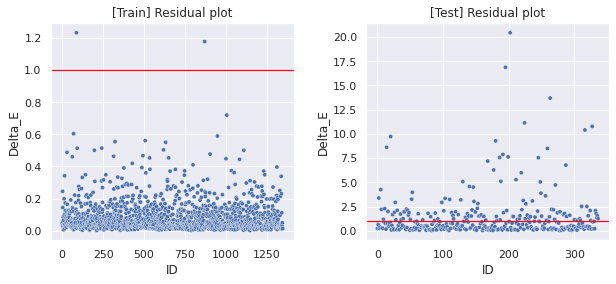

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

sns.scatterplot(ax=axes[0], x=df_train_pred.index, y=df_train_pred['Delta_E'], size=1, legend=False)
axes[0].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[0].set_title('[Train] Residual plot', fontsize=12)
axes[0].set_xlabel('ID')

sns.scatterplot(ax=axes[1], x=df_pred.index, y=df_pred['Delta_E'], size=1, legend=False)
axes[1].axhline(1.0, 0, 1, color='red', linewidth=1.2)
axes[1].set_title('[Test] Residual plot', fontsize=12)
axes[1].set_xlabel('ID')

plt.show()

## Feature Importances

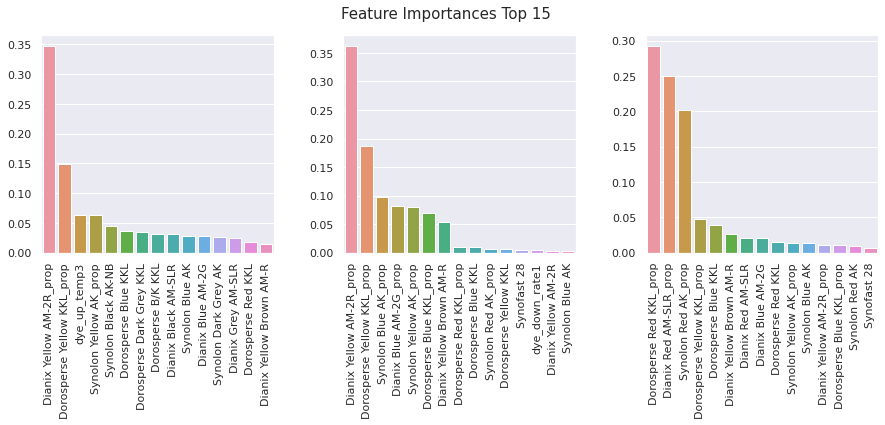

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
sns.set_theme(style='darkgrid')

topN = 15
fig.suptitle(f'Feature Importances Top {topN}', fontsize=15)

for i, ax in enumerate(axes):
    importances = model.estimators_[i].feature_importances_
    indices = np.argsort(importances)[::-1]

    g = sns.barplot(ax=ax, x=list(range(topN)), y=importances[indices[:topN]])
    g.set_xticks(range(topN))
    g.set_xticklabels(X_train.columns[indices[:topN]], rotation=90)

plt.show()